# Introduction

In the following notebook, I will be performing an EDA of some Airbnb data in the San Francisco area. This data pertains to the last calendar year, which at the time of this analysis would be December 2018 - December 2019.

In the following analysis, I will be looking to explore the data and answer the following questions:

- Based on the reviews of the last year, what makes a good user experience at a Airbnb rental? What makes a poor user experience? What would you advise to new Airbnb hosts to ensure high reviews and consistent renters?
- What are some of the seasonal Airbnb trends you've noticed in the San Francisco area? When are the down months over the last year? Which months are the most busy? Which areas were the most popular during these times? How have prices changed over time?
- Are airbnb's that are available for monthly rent competitive with the local markets?
- Can you create a price predictor for listings price? What features allows renters to charge more?


*GitHub Repo References*
The raw data files can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Data/01_Raw).

The raw data aggregation scripts can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Project%20Codes/01.%20Raw%20Data%20Aggregation%20Scripts).

The data cleaning scripts used to tidy the raw data aggregation can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Project%20Codes/02.%20Data%20Cleaning%20Scripts).

In [25]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd
import pandas_profiling

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set float format
pd.options.display.float_format = '{:.0f}'.format

#Ignore warnings
import warnings; warnings.simplefilter('ignore')

**Read in Data**

In [28]:
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

In [29]:
#Read in Airbnb Listings Data
listings = pd.read_csv(path + '01_04_2020_Listings_Cleaned.csv',index_col=0, low_memory=True, sep=',')

#Read in Airbnb Calendar and Reviews data
calendar = pd.read_csv(path + '01_04_2019_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=['date'], low_memory=True,index_col=0)

In [30]:
#Read in Zillow data
zillow = pd.read_csv(path + '12_29_2019_Zillow_Cleaned.csv', parse_dates=['Date'],
                     index_col=0, sep=',')

# Zillow

#### How has Airbnb grown over the last year(12/2018 - 12/2019)?

Let's begin by taking a look at the number of unique listings per month available for rent from Airbnb hosts.

In [50]:
calendar['month_year'] = pd.to_datetime(calendar['date']).dt.to_period('M')
#Set date as index for calendar data
calendar.set_index('date', inplace=True)

#Capture appropriate dates for analysis in Calendar data
calendar= calendar.loc['2018-12-01':'2019-12-31']

# #Convert calendar to dask
# calendar = dd.from_pandas(calendar, npartitions=3)

#Extract date info from index and assign as columns
calendar['year'] = calendar.index.year
calendar['month'] = calendar.index.month
calendar['weekday'] = calendar.index.weekday_name

#Check
calendar.head()

,adjusted_price,available,listing_id,maximum_nights,minimum_nights,price,year,month,month_year,weekday
date,,,,,,,,,,
2019-04-03,80,0,187730,120,3,80,2019,4,2019-04,Wednesday
2019-04-04,80,0,187730,120,3,80,2019,4,2019-04,Thursday
2019-04-05,82,1,187730,120,3,82,2019,4,2019-04,Friday
2019-04-06,82,1,187730,120,3,82,2019,4,2019-04,Saturday
2019-04-07,81,1,187730,120,3,81,2019,4,2019-04,Sunday


In [51]:
#Group last year by month_year and get a count of unique listings per day
last_year_daily = calendar.groupby(['date'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
last_year_daily =last_year_daily.rename(columns = {'nunique': 'listings'})

In [52]:
#Capture unique listings a month
last_year_monthly = calendar.groupby(['month_year'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
last_year_monthly =last_year_monthly.rename(columns = {'nunique': 'listings'})

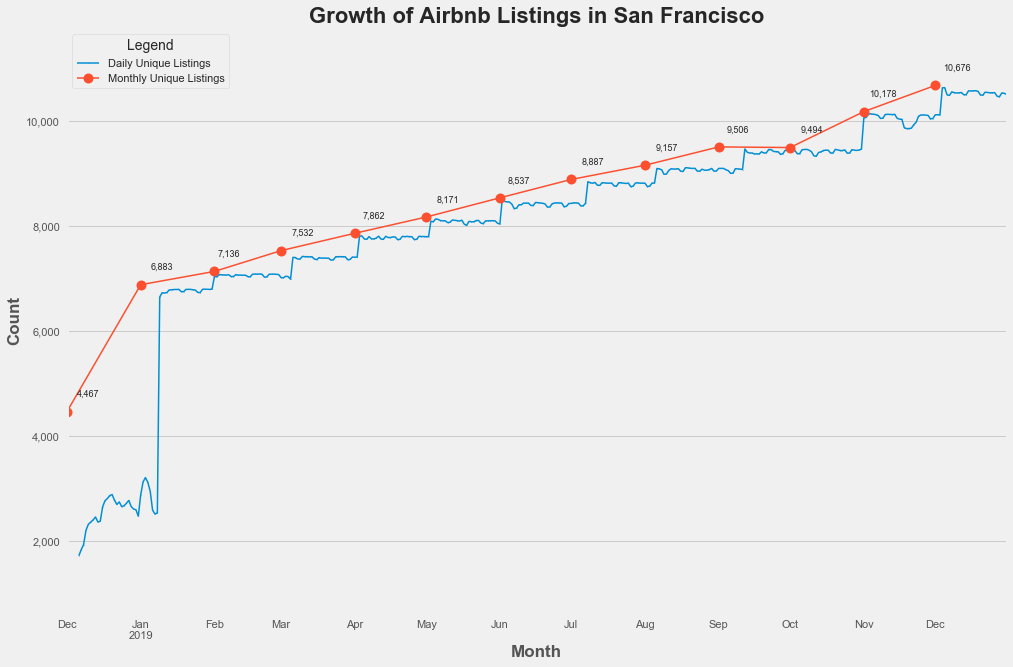

In [53]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Plot daily unique listings data
ax = last_year_daily.plot(x='date', y='listings', kind = 'line',style='o-', markersize=.5,
          label= 'Daily Unique Listings',figsize = (15,10),
         linewidth = 1.5)
 
#plot montly average
last_year_monthly.plot(x='month_year', y='listings',kind = 'line',style='o-', markersize= 10,
          label= 'Monthly Unique Listings',
         linewidth = 1.5 , ax=ax)

#Set fontdict
fontdict={'weight' : 'bold',
          'size': 17}

#Set x and y labels
ax.set_xlabel('Month',fontdict=fontdict)
ax.set_ylabel('Count', fontdict=fontdict)

#Format yticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

#Set Title
ax.set_title('Growth of Airbnb Listings in San Francisco', fontweight = 'bold', fontsize=22)

#Adjust plot margins
ax.margins(0,.12)

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Add Text
xs,ys=last_year_monthly['month_year'], last_year_monthly['listings']

for x,y in zip(xs,ys):
    label = '{:,}'.format(y)
    plt.annotate(label, (x,y),textcoords="offset points",fontsize = 9, xytext=(-50,15), ha='center')

#Set legend
plt.legend(title='Legend', frameon = True, loc='upper left');

Over the last year, there has been significant growth in the number of listings available for rent month to month. Let us look into the number of nights booked by users over the last year.

In [54]:
zillow.set_index(keys = 'Date', inplace=True)

In [55]:
zillow['Year'] = zillow.index.year
zillow['Month'] = zillow.index.month
zillow['Weekday_Name'] = zillow.index.weekday_name

In [56]:
zillow.head()

,City,County,Metro,Zip,State,SizeRank,Bedrooms,Median_Rent,Year,Month,Weekday_Name
Date,,,,,,,,,,,
2010-03-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200,2010,3,Monday
2010-04-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250,2010,4,Thursday
2010-05-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1200,2010,5,Saturday
2010-06-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1250,2010,6,Tuesday
2010-07-01,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,1225,2010,7,Thursday


# Time Series Analysis

For this analysis, we will isolate the rows in our Zillow data that are in the zipcode or city of the listings data.

In [57]:
#Capture zip information from listings
listings_zip = list(listings.zipcode.unique())

#Capture city information from listings 
listings_cities = list(listings.city.unique())

#Capture SF Data
sf_zillow = zillow[zillow['Zip'].isin(listings_zip) | zillow['City'].isin(listings_cities)]

#Check
print(sf_zillow.shape)
display(sf_zillow.tail())

(2015, 11)


,City,County,Metro,Zip,State,SizeRank,Bedrooms,Median_Rent,Year,Month,Weekday_Name
Date,,,,,,,,,,,
2019-11-01,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94105,CA,2269,2,5800,2019,11,Friday
2019-11-01,Sausalito,Marin,San Francisco-Oakland-Hayward,94965,CA,2434,2,3650,2019,11,Friday
2019-11-01,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94158,CA,2477,2,5288,2019,11,Friday
2019-11-01,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94110,CA,82,3,5575,2019,11,Friday
2019-11-01,San Francisco,San Francisco,San Francisco-Oakland-Hayward,94115,CA,518,3,6500,2019,11,Friday


In [ ]:
#SF vs rest of US Rent

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,5))
sf_zillow.groupby('Date')['Median_Rent'].mean().plot(kind = 'line')

zillow.loc['2011-09-01':'2019-11-01'].groupby(['Date'])['Median_Rent'].mean().plot(x_compat=True, kind = 'line', color= 'g')#green


#We also noted each state's region size ranking, which represents how big it is population-wise;
#California is ranked No. 1 with the largest population of all states, while Wyoming is ranked No. 51
zillow[zillow.SizeRank < 10].loc['2011-09-01':'2019-11-01'].groupby(['Date'])['Median_Rent'].mean().plot(x_compat=True, kind = 'line')

Airbnb monthly rent vs bay area rent 

In [ ]:
#Capture id and monthly_price from listings data for merge with calendar data
to_merge = listings[['id','monthly_price']]



In [ ]:
monthly_listings_dd = calendar_dd.merge(to_merge, left_on='listing_id', right_on='id')

In [ ]:
monthly_listings = monthly_listings_dd.compute()

In [ ]:
test_pd=test_pd[-test_pd.monthly_price.isna()]

test_pd.drop_duplicates(inplace = True)

In [ ]:
#Convert date to month-year format
test_pd
#test_pd['date'] = pd.to_datetime(test_pd['date']).dt.to_period('M')

In [ ]:
test_pd.set_index('date', inplace=True)

In [ ]:
test_pd.sort_index(inplace=True)

In [ ]:
test_pd['Year'] = test_pd.index.year
test_pd['Month'] = test_pd.index.month
test_pd['Weekday Name'] = test_pd.index.weekday_name

In [ ]:
test_pd.head()

In [ ]:
test_pd.loc['2018-09':'2019-12'].groupby('date')['monthly_price'].mean().plot()

In [ ]:
sf_zillow.loc['2018-09':'2019-12'].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line')

In [ ]:
#test_pd.loc['2018-09':'2019-12'].groupby('date')['monthly_price'].mean().plot(kind = 'box')
sns.boxplot(x='Month', y = 'monthly_price', data = test_pd)

In [ ]:
sf_zillow.tail()

In [ ]:
calendar.head()

* Comparing monthly rent of airbnb to zillow

In [ ]:
listings.head(2)

In [ ]:
#test = sf_zillow.groupby(['Bedrooms', 'Date'])['Median_Rent'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10,5))

sf_zillow.groupby("Bedrooms")['Median_Rent'].plot(kind="line", ax=ax)
plt.legend(title='Bedrooms', frameon = True, loc='upper right', labels=['studio', 'single','two','three'])


# Other variables and relationships worth exploring

### Principal Component Analysis